## Reduced Rank Regression

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings

# Ignore runtime warning since we have very small values
warnings.filterwarnings("ignore", category=RuntimeWarning)



sys.path.append(os.path.join(os.getcwd(), 'utils'))

from utils.data_loading import *
from utils.data_processing import *
from utils.regression import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# autoreload
%reload_ext autoreload
%autoreload 2

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')

print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Load the data
current_dir = os.getcwd()
print("Loading the data...")
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')
print("Data loaded successfully!")

Loading the data...
Loading data from ssp585_time_series.pkl
Data loaded successfully.
Data loaded successfully!


In [3]:
filtered_data = filter_data(data)

Filtering data...


100%|██████████| 72/72 [00:00<00:00, 32343.35it/s]

Data filtered. Kept 34 models


In [4]:
# Print the shape of the first run in the first model of filtered_data
first_model = list(filtered_data.keys())[0]
first_run = list(filtered_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {filtered_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


In [5]:
# Create a NaN mask to remove any cells which have 1 >= NaNs

nan_mask = create_nan_mask(filtered_data)

Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 16.03it/s]

NaN mask created.


In [6]:
# Apply the NaN mask to every single run (modifications done in place for memory efficiency)

masked_data = mask_out_nans(filtered_data, nan_mask)

Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 26.53it/s]

NaN values masked out.


In [7]:
# Print the shape of the first run in the first model of masked_data
first_model = list(masked_data.keys())[0]
first_run = list(masked_data[first_model].keys())[0]
print(f"Shape of the first run in the first model: {masked_data[first_model][first_run].shape}")

Shape of the first run in the first model: (165, 72, 144)


## The NaN mask has been applied and only the models with more than 4 runs have been kept

In [8]:
print(f"There are exactly {len(masked_data.keys())} models of the {len(data.keys())} that remain.")

There are exactly 34 models of the 72 that remain.


## Only keep 15 models to make processing time faster

In [9]:
selected_models = random.sample(list(masked_data.keys()), 15)
selected_models.append('CanESM5-1')
masked_data = {model: masked_data[model] for model in selected_models}

In [10]:
reshaped_data = reshape_data(masked_data)

Reshaping data...


100%|██████████| 16/16 [00:01<00:00, 11.59it/s]

Data reshaped.


In [11]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 72 runs.


In [12]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

### Calculate the forced response for each model, assuming that it is the mean of all the runs

In [13]:
data_forced_responses = add_forced_response(reshaped_data) # The forced response is not correctly normalized yet (this is done by the normalize function below)

Adding the forced response to the data...


100%|██████████| 16/16 [00:01<00:00,  8.10it/s]

Forced response added.


In [14]:
# Print the shape of a random run from a random model

random_model = random.choice(list(data_forced_responses.keys()))
random_run = random.choice(list(data_forced_responses[random_model].keys()))
print(f"Shape of the random run: {data_forced_responses[random_model][random_run].shape}")

Shape of the random run: (165, 10368)


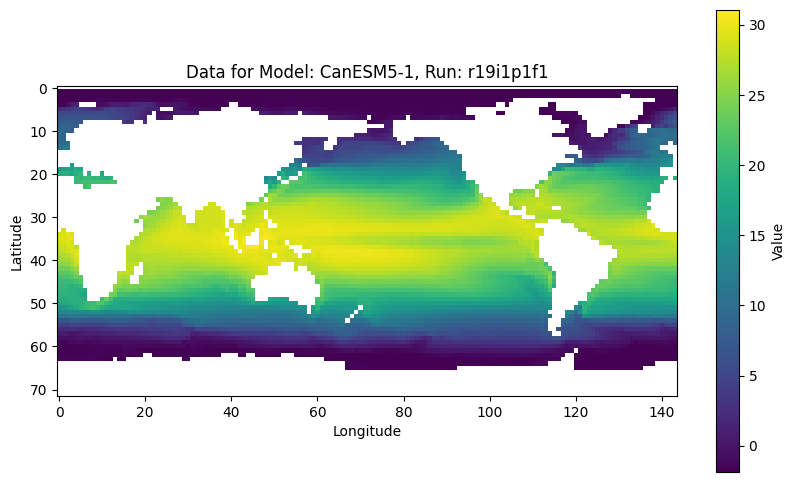

In [15]:
# Reshape the data to the original grid shape
data_grid = data_forced_responses[random_model][random_run][150].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(10, 6))
plt.imshow(data_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Data for Model: {random_model}, Run: {random_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [16]:
# Animate the data
random_data_to_animate = data_forced_responses[random_model][random_run].reshape(-1, 72, 144)
ground_truth_animation = animate_data(random_data_to_animate, interval=200, cmap='viridis', title=f'Ground Truth: {random_model}, Run: {random_run}')

display(HTML(ground_truth_animation.to_html5_video()))

## At this point, the data still contains NaNs, corresponding to the continents

In [17]:
data_without_nans = remove_nans_from_grid(data_forced_responses, nan_mask)

Removing NaN values from the grid...


100%|██████████| 16/16 [00:00<00:00, 35.10it/s]

NaN values removed.


In [18]:
len(data_without_nans.keys())

16

In [19]:
# Print the shape of a random run from a random model (same as above)
print(f"The shape of the data without NaNs: {data_without_nans[random_model][random_run].shape}")

The shape of the data without NaNs: (165, 6523)


## Now the NaNs have been completely removed from the data

### The data is now in the shape : Time x # of grid cells without NaNs

In [20]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data_without_nans.keys()))
train_models = [model for model in data_without_nans.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data_without_nans[model] for model in train_models}
test_data = {test_model: data_without_nans[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['MPI-ESM1-2-LR', 'GISS-E2-2-H', 'GISS-E2-2-G', 'CESM2-FV2', 'EC-Earth3-Veg', 'ACCESS-CM2', 'MIROC6', 'CNRM-ESM2-1', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'GISS-E2-1-H', 'CMCC-CM2-SR5', 'E3SM-2-0-NARRM', 'FGOALS-g3', 'CanESM5-1']
Testing model: CESM2


In [21]:
# Normalize the data
normalized_train_data, normalized_test_data, training_statistics, testing_statistics = normalize_data(train_data, test_data)

Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 15.77it/s]

Data normalization completed.


In [22]:
normalized_test_data[test_model]['forced_response'].shape

(165, 6523)

In [23]:
# Plot the normalized test data
normalized_test_data_grid = readd_nans_to_grid(normalized_test_data[test_model]['forced_response'], nan_mask, True).reshape(-1, 72, 144)
animated_test_data = animate_data(normalized_test_data_grid, interval=200, cmap='viridis', title=f'Normalized Test Data: {test_model}')
display(HTML(animated_test_data.to_html5_video()))

Re-adding NaN values to the grid...


Selected model: E3SM-2-0-NARRM, run: forced_response.
Shape of the normalized data: (165, 6523).
Shape of the original data: (165, 6523).


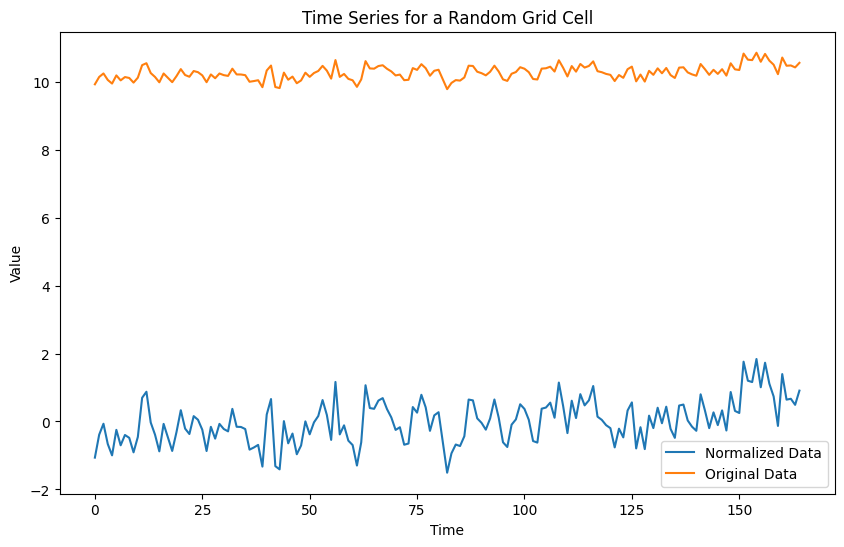

In [24]:
# make a few plots using normalized_train_data and train_data by selecting a random grid cell and plotting the time series
random_model = random.choice(list(normalized_train_data.keys()))
random_run = random.choice(list(normalized_train_data[random_model].keys()))

print(f"Selected model: {random_model}, run: {random_run}.")

# print dimensions of the data
print(f"Shape of the normalized data: {normalized_train_data[random_model][random_run].shape}.")
print(f"Shape of the original data: {train_data[random_model][random_run].shape}.")

# select a random grid cell
random_cell = random.randint(0, 6523)
time_series_normalized = normalized_train_data[random_model][random_run][:, random_cell]
time_series_original = train_data[random_model][random_run][:, random_cell]

# plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_normalized, label='Normalized Data')
plt.plot(time_series_original, label='Original Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series for a Random Grid Cell')
plt.legend()
plt.show()

## Now that the data has been normalized (and NaN values removed), it's time to do the Reduced Rank Regression (RRR)

In [25]:
# First pool the data together
X_full, Y_full = pool_data(normalized_train_data)

Pooling data...


100%|██████████| 15/15 [00:00<00:00, 234755.82it/s]

Data pooled.


In [26]:
X_full.shape, Y_full.shape # Shape is correct

((49335, 6523), (49335, 6523))

In [27]:
rank = 10 # Used as a starting point
lambda_ = 1 # This will be optimized later
Brr, B_ols = reduced_rank_regression(X_full, Y_full, rank, lambda_)

Fitting OLS...
RRR completed.


In [28]:
print("Checking X:")
print("NaN values:", np.isnan(X_full).any())
print("Inf values:", np.isinf(X_full).any())
print("Max value:", np.max(X_full))
print("Min value:", np.min(X_full))

print("Checking y:")
print("NaN values:", np.isnan(Y_full).any())
print("Inf values:", np.isinf(Y_full).any())
print("Max value:", np.max(Y_full))
print("Min value:", np.min(Y_full))

Checking X:
NaN values: False
Inf values: False
Max value: 87.08647416779486
Min value: -13.770887280773467
Checking y:
NaN values: False
Inf values: False
Max value: 6.078075924981205
Min value: -3.3062565004055693


## Plot the MSE for on the Training dataset

100%|██████████| 15/15 [00:14<00:00,  1.00it/s]
/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_11187/1473404141.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels)


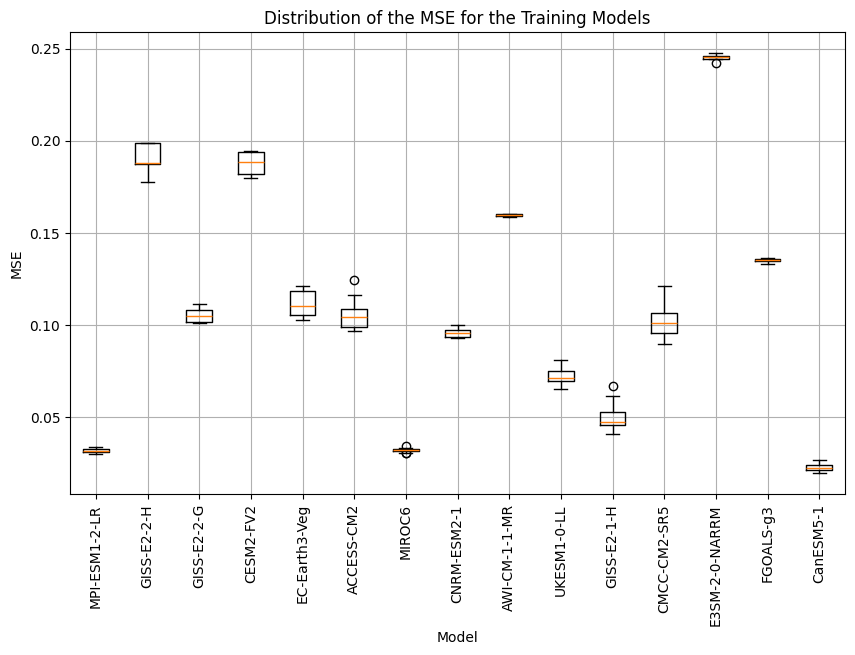

In [29]:
# Plot the distribution of the MSE by taking the average MSE for each model and make a boxplot

mse_values_train = calculate_mse_distribution(normalized_train_data, Brr)
labels = list(mse_values_train.keys())
values = list(mse_values_train.values())
plt.figure(figsize=(10, 6))
plt.boxplot(values, labels=labels)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Distribution of the MSE for the Training Models')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [30]:
mse_values_train

{'MPI-ESM1-2-LR': [0.03183536830024839,
  0.032828147025636384,
  0.030785027465862064,
  0.03294779551219349,
  0.03276768811261372,
  0.03271384296197484,
  0.030951037689149783,
  0.032331950343236944,
  0.03194931836129109,
  0.032148920138843615,
  0.03336673837485945,
  0.031044966176171883,
  0.03248241499871981,
  0.03394109009833371,
  0.03170169374934496,
  0.03199569088336508,
  0.03024714408545191,
  0.032117079307956896,
  0.03267456368916573,
  0.03163451415941335,
  0.032010410100892735,
  0.03058596727928753,
  0.03185469961859525,
  0.03079993619425295,
  0.030424389569939366,
  0.03334633297490779,
  0.03163025846373758,
  0.031273877342504405,
  0.03315052578446059,
  0.03189446048693783,
  0.033025893085247206,
  0.031178710641311422,
  0.03160471962790451,
  0.031292447369695824,
  0.03060785416645405,
  0.030057541931926095,
  0.03249894894401898,
  0.033160447636340365,
  0.03088559329620631,
  0.031470890341495104,
  0.032629235512119575,
  0.03103054649948974,


In [31]:
# Do a Sanity check to see if the rank is correct and if Brr is sparse or not
cross_validation = False
sanity = sanity_check(Brr, B_ols, rank, cross_validation)

Is B_rr sparse: False
The rank of Bols is 2460 and the rank of B_rr is 10.
The mean of B_rr is 9.785156124676652e-05 and the std is 0.021821283931892317.


In [32]:
# print mean and std of X_full and Y_full

print(f"Mean of X_full: {np.mean(X_full)}")
print(f"Std of X_full: {np.std(X_full)}")
print(f"Mean of Y_full: {np.mean(Y_full)}")
print(f"Std of Y_full: {np.std(Y_full)}")

Mean of X_full: 5.340422349236135e-16
Std of X_full: 0.9999999999999997
Mean of Y_full: 6.391274840640202e-16
Std of Y_full: 0.5271956901617851


In [33]:
Brr.shape, B_ols.shape

((6523, 6523), (6523, 6523))

In [34]:
# Test a prediction on the test set for a single run

# Select a random run from the test set
test_model = list(normalized_test_data.keys())[0]
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
test_run = normalized_test_data[test_model][random.choice(test_runs)]
ground_truth = normalized_test_data[test_model]['forced_response']

In [35]:
test_run.shape, ground_truth.shape

((165, 6523), (165, 6523))

In [36]:
# make the prediction

prediction = test_run @ B_ols # use test_run @ B_ols for the OLS prediction or test_run @ Brr for the reduced rank regression prediction
prediction.shape

(165, 6523)

In [37]:
# Add the NaN values back to the correct spots
predictions = True
prediction = readd_nans_to_grid(prediction, nan_mask, predictions)
test_run = readd_nans_to_grid(test_run, nan_mask, predictions)
ground_truth = readd_nans_to_grid(ground_truth, nan_mask, predictions)

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


In [38]:
prediction.shape, test_run.shape, ground_truth.shape

((165, 10368), (165, 10368), (165, 10368))

Displaying the forced response and runs for grid spot: [29 37]


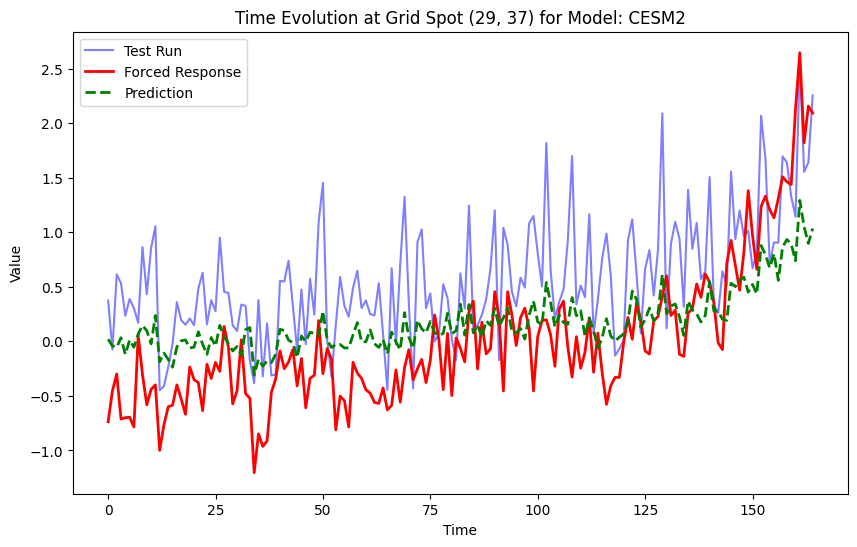

In [39]:
# Select a random grid spot
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run (minus the forced response)
input_data = test_run.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the forced response
forced_response_data = ground_truth.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the prediction
predicted_data = prediction.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs, the forced response, and the prediction
plt.figure(figsize=(10, 6))
plt.plot(input_data, color='blue', alpha=0.5, label='Test Run')
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.plot(predicted_data, color='green', label='Prediction', linewidth=2, linestyle='--')
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {test_model}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [40]:
print(f"The shape of the data is: {X_full.shape}")
print(f"The shape of the target is: {Y_full.shape}")
print(f"The maximum, minimum, average and std for the input data are: {np.max(X_full)}, {np.min(X_full)}, {np.mean(X_full)}, {np.std(X_full)}")
print(f"The maximum, minimum, average and std for the target data are: {np.max(Y_full)}, {np.min(Y_full)}, {np.mean(Y_full)}, {np.std(Y_full)}")

The shape of the data is: (49335, 6523)
The shape of the target is: (49335, 6523)
The maximum, minimum, average and std for the input data are: 87.08647416779486, -13.770887280773467, 5.340422349236135e-16, 0.9999999999999997
The maximum, minimum, average and std for the target data are: 6.078075924981205, -3.3062565004055693, 6.391274840640202e-16, 0.5271956901617851


Random timestamp: 3


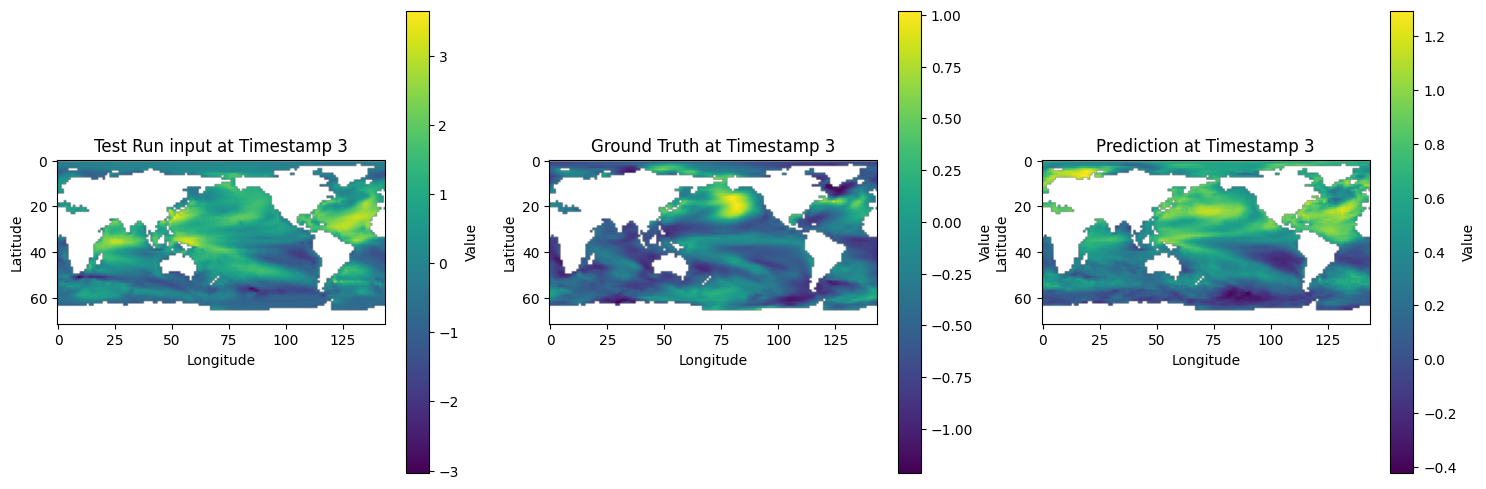

In [41]:
# Plot a random timestamp for the target and prediction

random_timestamp = random.randint(0, prediction.shape[0])
print(f"Random timestamp: {random_timestamp}")

# Data for the target
# Reshape the data to the original grid shape
test_run_grid = test_run[random_timestamp, :].reshape(72, 144)
ground_truth_grid = ground_truth[random_timestamp, :].reshape(72, 144)
prediction_grid = prediction[random_timestamp, :].reshape(72, 144)

# Plot the data using plt.imshow
plt.figure(figsize=(18, 6))

# Plot the test run
plt.subplot(1, 3, 1)
plt.imshow(test_run_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Test Run input at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the ground truth (forced response)
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Ground Truth at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(prediction_grid, cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Prediction at Timestamp {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [42]:
# Calculate the MSE of the predictions vs the ground truth
prediction.shape, ground_truth.shape

((165, 10368), (165, 10368))

## Compute the MSE for each of the runs using the RRR

In [43]:
normalized_test_data.keys()

dict_keys(['CESM2'])

Model: CESM2, Run: r10i1p1f1, MSE: 0.5817627466589985
Model: CESM2, Run: r11i1p1f1, MSE: 0.5942561728888289
Model: CESM2, Run: r1i1p1f1, MSE: 0.5867936972789707
Model: CESM2, Run: r2i1p1f1, MSE: 0.5928778468458211
Model: CESM2, Run: r3i1p1f1, MSE: 0.6060904543289668
Model: CESM2, Run: r4i1p1f1, MSE: 0.583281909811843
Model: CESM2, Run: r5i1p1f1, MSE: 0.6131540228205409
Model: CESM2, Run: r6i1p1f1, MSE: 0.573350203414706
Model: CESM2, Run: r7i1p1f1, MSE: 0.6145214583401625
Model: CESM2, Run: r8i1p1f1, MSE: 0.6088540100155718
Model: CESM2, Run: r9i1p1f1, MSE: 0.6067795292139607


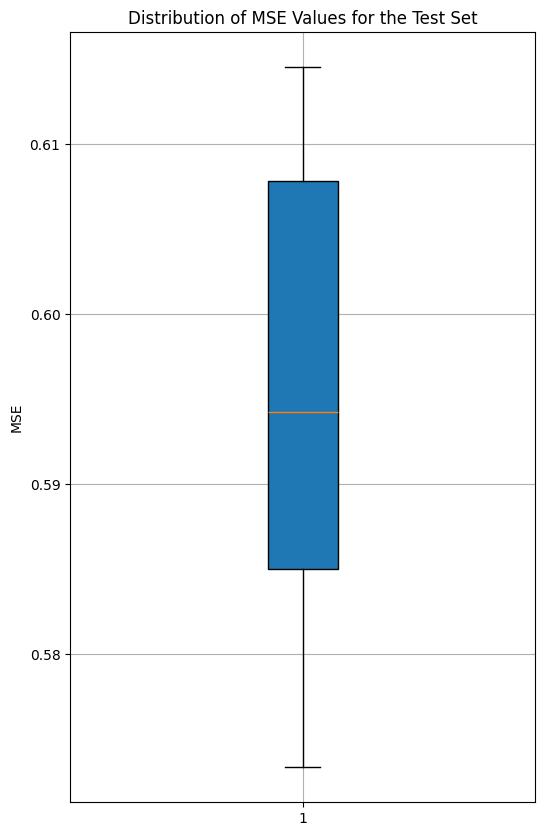

In [44]:
# Calculate the MSE for each of the runs in the test set

test_model_mse = []
for model in normalized_test_data:
    for run in normalized_test_data[model]:
        if run == 'forced_response':
            continue
        test_run = normalized_test_data[model][run]
        ground_truth = normalized_test_data[model]['forced_response']
        run_mse = calculate_mse(test_run, Brr, ground_truth)
        test_model_mse.append(run_mse)
        print(f"Model: {model}, Run: {run}, MSE: {run_mse}")
        
# Plot the distribution of the MSE values
plt.figure(figsize=(6, 10))
plt.boxplot(test_model_mse, vert=True, patch_artist=True)
plt.ylabel('MSE')
plt.title('Distribution of MSE Values for the Test Set')
plt.grid(True)
plt.show()

## Finally plot the animations of all the test runs and compare them to the ground truth

In [45]:
num_runs = 3
plot_animations(test_model, normalized_test_data, Brr, nan_mask, num_runs)

Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...


Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
Re-adding NaN values to the grid...
